In [1]:
import netCDF4
import numpy as np
import pandas as pd
import xarray

import cftime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs

In [2]:
f = netCDF4.Dataset("ghcn-dsg.nc")

# Plots

The numbers of the plots indicate the plot in the work *GHCN-Daily: a treasure trove of climate data awaiting discovery* (https://doi.org/10.1016/j.cageo.2018.07.003).

## Fig. 1

Number of operational weather stations within the GHCN-Daily database recording precipitation data per 5° grid cell in a) 1900, b) 1925, c) 1950, d) 1975, e) 2000 and f) 2017.

In [24]:
counts = {1900: [], 1925: [] , 1950: [], 1975: [], 2000: [], 2017: []}
stations = netCDF4.chartostring(f["station"][...])

year_datenums = {}
for year in counts:
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        ndays = 366  # leap year
    else:
        ndays = 365

    dates = cftime.date2num(
        cftime.num2date(np.arange(ndays), f"days since {year}-01-01", "gregorian"),
        f["time"].getncattr("units"),
        f["time"].getncattr("calendar")
    ).astype(int)
    year_datenums[year] = dates

frm = 0
for i, size in enumerate(f["rowSize"][...]):
    to = frm + size
    pr = f["pr"][frm:to]
    nctime = f["time"][frm:to].astype(int)

    for year in counts:
        year_dates = year_datenums[year]
        mask = np.isin(nctime, year_dates)
        pr_year = pr[mask]

        if pr_year.size:
            counts[year].append(i)

    frm = to  # next station starting point

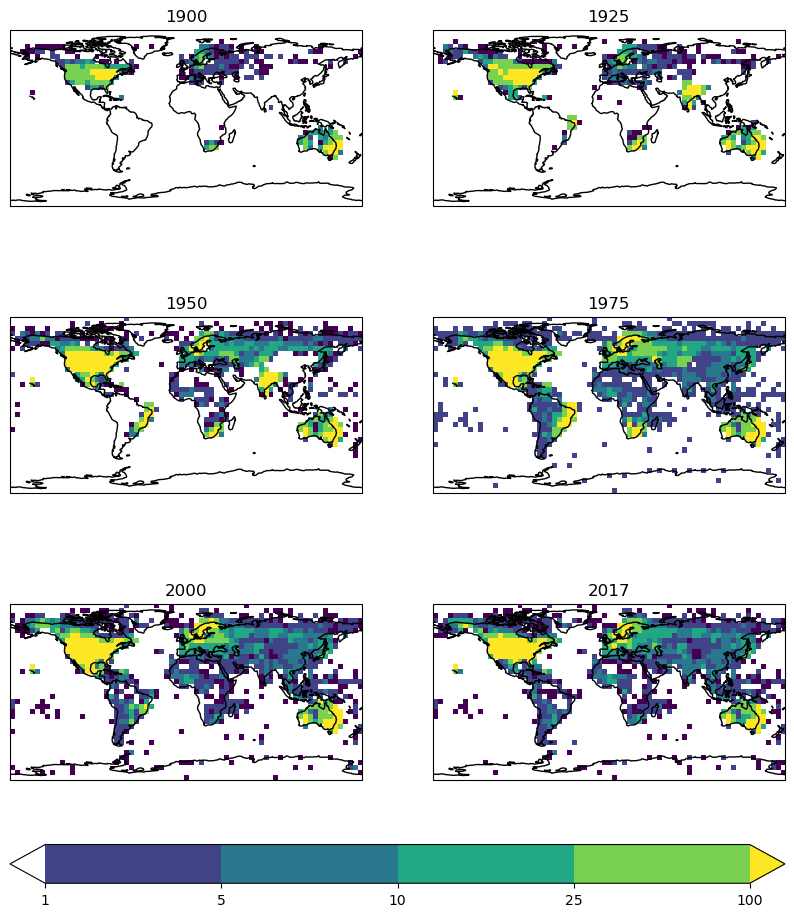

In [26]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(10, 12),
    subplot_kw={'projection': ccrs.PlateCarree()})

# Discrete colorbar
boundaries = [1, 5, 10, 25, 100]
cmap = plt.get_cmap('viridis')
cmap.set_under('white')
norm = mcolors.BoundaryNorm(boundaries, cmap.N, extend='both')

for i, (year, ax) in enumerate(zip(counts.keys(), axes.flat)):
    # Histogram
    x_points = f["lon"][counts[year]]
    y_points = f["lat"][counts[year]]
    x_grid, y_grid = np.meshgrid(np.arange(-180, 180, 5), np.arange(-90, 90, 5))
    # Count the number of points in each cell
    hist, x_edges, y_edges = np.histogram2d(x_points, y_points, bins=[x_grid[0], y_grid[:, 0]])

    # Plot
    im = ax.imshow(hist.T, cmap=cmap, norm=norm, extent=(-180.0, 180.0, -90.0, 90.0), origin="lower")
    ax.set_title(f'{year}')
    ax.coastlines()
    ax.set_extent((-180.0, 180.0, -90.0, 90.0))

fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='horizontal', fraction=0.05, pad=0.07, boundaries=boundaries)
# plt.tight_layout()  # Adjust layout to avoid overlap
plt.savefig("figures/stations_years.svg")
plt.show()

## Fig. 4

Fig. 4. Total number of weather stations per country or territory contained in the GHCN-Daily database. All sources with at least 100 weather stations are listed.

In [8]:
import urllib.request

country_codes = netCDF4.chartostring(f["station"][:, :2])
countries_url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt"

with urllib.request.urlopen(countries_url) as fin:
    fips_df = pd.DataFrame(
        [line.rstrip("\n").split(" ", 1) for line in fin.read().decode("utf-8").split("\n")],
        columns=["fips", "name"]
    ).dropna().set_index("fips")

codes, counts = np.unique(country_codes, return_counts=True)
counts_df = pd.DataFrame.from_dict({"fips": codes, "counts": counts}).set_index("fips")

df = fips_df.join(counts_df)
df100 = df[df["counts"] > 100].sort_values("counts", ascending=False)

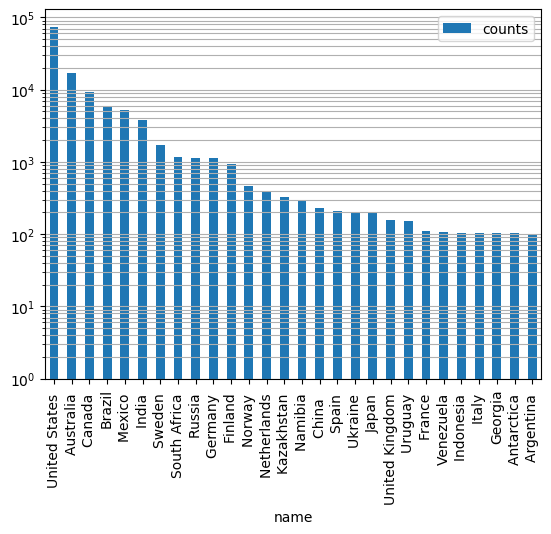

In [23]:
ax = df100.drop(index=["RQ"]).plot.bar(x="name", y="counts", log=True, layout='constrained')
ax.yaxis.grid(True, which='both', linestyle='-')

plt.savefig("figures/country_dist.svg")

## Fig. 5

Prevalence of a subset of GHCN-Daily variables (%) in weather station records within the United States and globally.

In [11]:
code = "US"
vs = ["tasmin", "tasmax", "pr", "snow", "snwd"]
US_count = [0]*len(vs)
International_count = [0]*len(vs)

stations = netCDF4.chartostring(f["station"][...])
frm = 0
for i, st in enumerate(stations):
    to = frm + f["rowSize"][i]

    for j, v in enumerate(vs):
        data = f[v][frm:to]
        count = (~data.mask).sum()

        if st.startswith(code):
            US_count[j] += count
        else:
            International_count[j] += count

    frm = to

df = pd.DataFrame.from_dict({"variable": vs, "US": US_count, "International": International_count})
total = (df["US"] + df["International"]).sum()
df["US%"] = df["US"] / total
df["International%"] = df["International"] / total

<Axes: xlabel='variable'>

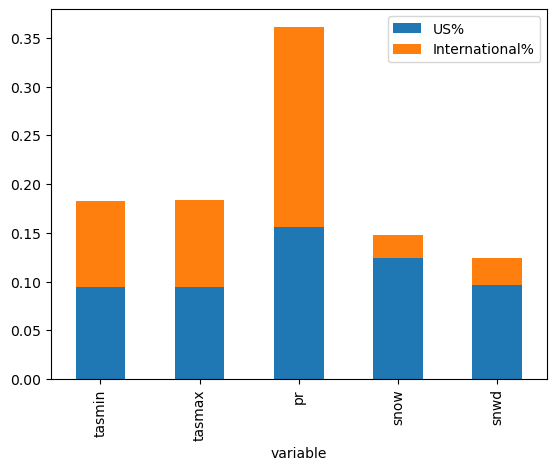

In [13]:
df.set_index("variable")[["US%", "International%"]].plot.bar(stacked=True)

## Fig.7

GHCN-Daily data availability of a,d) precipitation, b,e) minimum and c,f) maximum temperature. Figures a-c list the number of active weather stations per year. Figures d-f tally the years of activity of individual weather stations based on the number of months with a minimum of twenty observations (min20/month).

# Custom plots

## Histogram of number of days per station

In [14]:
counts = []
frm = 0
for to in f["rowSize"][...]:
    data = f["pr"][frm:to]
    if isinstance(data.mask, np.bool_) and not data.mask:
        st_obs = data.size
    elif isinstance(data.mask, np.ndarray):
        st_obs = (~data.mask).sum()
    else:
        st_obs = 0

    counts.append(st_obs)
    frm = to

counts = np.array(counts)

In [15]:
counts[counts < 31].size, counts[counts >= 31].size

(64435, 63557)

(array([3.6265e+04, 1.2936e+04, 8.4790e+03, 3.4280e+03, 1.8780e+03,
        5.4000e+02, 2.2000e+01, 7.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([3.10000e+01, 8.94680e+03, 1.78626e+04, 2.67784e+04, 3.56942e+04,
        4.46100e+04, 5.35258e+04, 6.24416e+04, 7.13574e+04, 8.02732e+04,
        8.91890e+04]),
 <BarContainer object of 10 artists>)

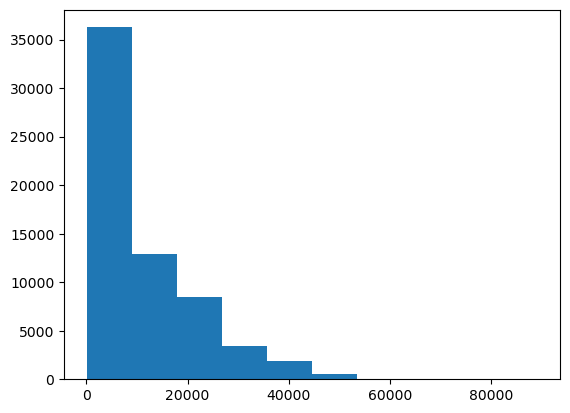

In [16]:
plt.hist(counts, range=(31,counts.max()))